In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import torch
import mlflow

from dataclasses import asdict

from flow_mnist.train import Trainer
from flow_mnist.data import MNISTDataset
from flow_mnist.config import load_config
from flow_mnist.model import FlowModel, AutoEncoder
from flow_mnist.flow import MNISTSampleable, NormalSampleable, OTFlowPath

In [ ]:
torch.manual_seed(42)
os.chdir("..") if not os.path.exists("config.yaml") else None
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
conf = load_config("config.yaml")

In [ ]:
mlflow.set_tracking_uri(conf.log.server.uri)
mlflow.set_experiment("MNIST Flow Matching")

<Experiment: artifact_location='mlflow-artifacts:/417261536112185923', creation_time=1750021081611, experiment_id='417261536112185923', last_update_time=1750021081611, lifecycle_stage='active', name='MNIST Flow Matching', tags={}>

In [ ]:
data_mnist = MNISTDataset(**asdict(conf.data))

ot_path = OTFlowPath()
p_init_norm = NormalSampleable((4, 4, 4))
p_data_mnist = MNISTSampleable(dataset=data_mnist)

vae = AutoEncoder(**asdict(conf.model.vae)).to(device)
flow_model = FlowModel(**asdict(conf.model.flow)).to(device)

In [ ]:
trainer = Trainer(
    logger=conf.log.param,
    **asdict(conf.train),
    p_data=p_data_mnist,
    p_init=p_init_norm,
    f_model=flow_model,
    f_path=ot_path,
    device=device,
    vae=vae,
)

loss.item() = 2.08:   0%|          | 0/40000 [00:00<?, ?it/s]

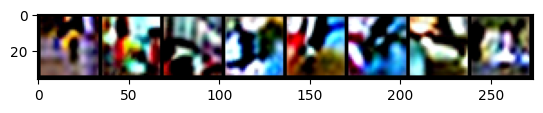

loss.item() = 2.08:   0%|          | 78/40000 [00:05<50:02, 13.29it/s] 


🏃 View run ambitious-moose-288 at: http://127.0.0.1:8080/#/experiments/417261536112185923/runs/922191c044054eb0b84b6e9f4f602b3f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/417261536112185923


KeyboardInterrupt: 

In [ ]:
with mlflow.start_run():
    mlflow.log_params(asdict(conf.model.flow))
    mlflow.log_params(asdict(conf.train))
    mlflow.set_tag("debug", True)
    trainer.train()

In [ ]:
torch.save(flow_model.state_dict(), conf.path.storage / 'flow.pt')